In [9]:
import numpy as np
import pandas as pd
import json
import clustering_benchmark_helper as cbh
from tqdm import tqdm
import importlib
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

importlib.reload(cbh)

import warnings
warnings.filterwarnings("ignore")


In [10]:
ambiguity_score_path = "../scatterplots/sampling/ambiguity_1_1.0253166008287824.npy"
ambiguity_score = np.load(ambiguity_score_path)
keys = np.load("../scatterplots/userstudy_ambiguity/keys.npy")

scatterplot_dict = {}
for i, key in enumerate(keys):
	scatterplot_dict[key] = np.load(f"../scatterplots/scatterplots/{key}")[::10]

In [21]:
scorer = cbh.silhouette_scorer
hdbscan_scores = []
dbscan_scores = []
kmeans_scores = []
xmeans_scores = []
birch_scores = []
agglo_complete_scores = []
agglo_average_scores = []
agglo_single_scores = []

for key, scatterplot in tqdm(scatterplot_dict.items()):
	hdbscan_scores.append(cbh.hdbscan_scorer(scatterplot, scorer))
	dbscan_scores.append(cbh.dbscan_scorer(scatterplot, scorer))
	kmeans_scores.append(cbh.kmeans_scorer(scatterplot, scorer))
	xmeans_scores.append(cbh.xmeans_scorer(scatterplot, scorer))
	birch_scores.append(cbh.birch_scorer(scatterplot, scorer))
	agglo_complete_scores.append(cbh.agglo_scorer(scatterplot, scorer, linkage="complete"))
	agglo_average_scores.append(cbh.agglo_scorer(scatterplot, scorer, linkage="average"))
	agglo_single_scores.append(cbh.agglo_scorer(scatterplot, scorer, linkage="single"))

# for key, scatterplot in tqdm(scatterplot_dict.items()):
# 	hdbscan_scores.append(cbh.hdbscan_naive_scorer(scatterplot, scorer))
# 	dbscan_scores.append(cbh.dbscan_naive_scorer(scatterplot, scorer))
# 	kmeans_scores.append(cbh.kmeans_naive_scorer(scatterplot, scorer))
# 	xmeans_scores.append(cbh.xmeans_naive_scorer(scatterplot, scorer))
# 	birch_scores.append(cbh.birch_naive_scorer(scatterplot, scorer))
# 	agglo_complete_scores.append(cbh.agglomerative_naive_scorer(scatterplot, scorer, linkage="complete"))
# 	agglo_average_scores.append(cbh.agglomerative_naive_scorer(scatterplot, scorer, linkage="average"))
# 	agglo_single_scores.append(cbh.agglomerative_naive_scorer(scatterplot, scorer, linkage="single"))

100%|██████████| 60/60 [24:18<00:00, 24.30s/it]


In [22]:
metric = "silhouette"

np.save(f"./clustering_benchmark/hdbscan_{metric}_scores.npy", hdbscan_scores)
np.save(f"./clustering_benchmark/dbscan_{metric}_scores.npy", dbscan_scores)
np.save(f"./clustering_benchmark/kmeans_{metric}_scores.npy", kmeans_scores)
np.save(f"./clustering_benchmark/xmeans_{metric}_scores.npy", xmeans_scores)
np.save(f"./clustering_benchmark/birch_{metric}_scores.npy", birch_scores)
np.save(f"./clustering_benchmark/agglo_complete_{metric}_scores.npy", agglo_complete_scores)
np.save(f"./clustering_benchmark/agglo_average_{metric}_scores.npy", agglo_average_scores)
np.save(f"./clustering_benchmark/agglo_single_{metric}_scores.npy", agglo_single_scores)

In [23]:
metric = "calinski"

def plot(metric, ax):

	hdbscan_scores = np.load(f"./clustering_benchmark/hdbscan_{metric}_scores.npy")
	dbscan_scores = np.load(f"./clustering_benchmark/dbscan_{metric}_scores.npy")
	kmeans_scores = np.load(f"./clustering_benchmark/kmeans_{metric}_scores.npy")
	xmeans_scores = np.load(f"./clustering_benchmark/xmeans_{metric}_scores.npy")
	birch_scores = np.load(f"./clustering_benchmark/birch_{metric}_scores.npy")
	agglo_complete_scores = np.load(f"./clustering_benchmark/agglo_complete_{metric}_scores.npy")
	agglo_average_scores = np.load(f"./clustering_benchmark/agglo_average_{metric}_scores.npy")
	agglo_single_scores = np.load(f"./clustering_benchmark/agglo_single_{metric}_scores.npy")

	top_ambiguity_score_index = np.argsort(ambiguity_score)[::-1][:20]
	bottom_ambiguity_score_index = np.argsort(ambiguity_score)[:20]
	middle_ambiguity_score_index = np.argsort(ambiguity_score)[20:40]

	index_lists      = [bottom_ambiguity_score_index, middle_ambiguity_score_index, top_ambiguity_score_index]
	index_name_lists = ["$\mathcal{P}_l$", "$\mathcal{P}_m$", "$\mathcal{P}_h$"]
	scores_list = [
		hdbscan_scores,
		dbscan_scores,
		kmeans_scores,
		xmeans_scores,
		birch_scores,
		agglo_complete_scores,
		agglo_average_scores,
		agglo_single_scores
	]

	index_to_corrs = {}

	## naive rank correlation test
	for idx, index_list in enumerate(index_lists):
		corrs = []
		for i in range(len(index_list)):
			for j in range(0, i):
				i_score_list = []
				j_score_list = []
				for scores in scores_list:
					i_score_list.append(scores[index_list[i]])
					j_score_list.append(scores[index_list[j]])
				
				corr = spearmanr(i_score_list, j_score_list)
				corrs.append(corr[0])
		
		index_to_corrs[index_name_lists[idx]] = corrs
	
	keys = []
	values = []

	for key, value in index_to_corrs.items():
		keys += [key] * len(value)
		values += value

	df = pd.DataFrame({
		"Scatterplot": keys,
		"Correlation": values
	})

	sns.boxplot(x="Correlation", y="Scatterplot", data=df, ax=ax)

	ax.set_ylabel("")
	if metric == "silhouette":
		ax.set_title("(a) Silhouette Coefficient")
	elif metric == "calinski":
		ax.set_title("(b) Calinski-Harabasz Index")
	ax.set_xlabel("Pairwise Correlation")

	return df


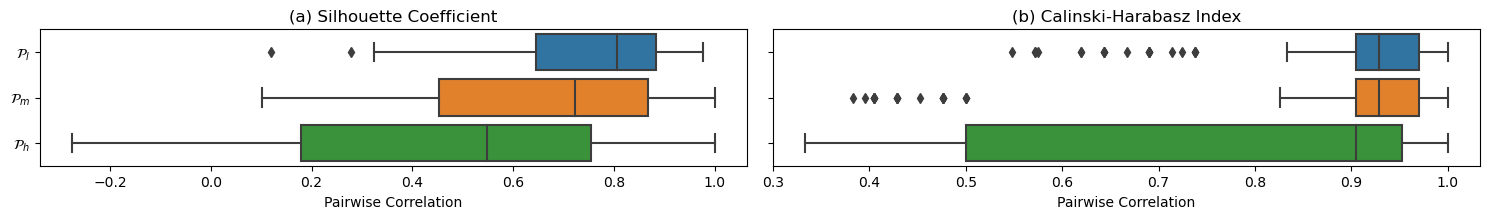

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(15, 2.3), sharey=True)

sil_df = plot("silhouette", ax[0])
cal_df = plot("calinski", ax[1])

plt.tight_layout()
plt.savefig("./clustering_benchmark/plot/result.pdf", dpi=300)
plt.savefig("./clustering_benchmark/plot/result.png", dpi=300)
plt.show()

In [25]:
## run anova test

import statsmodels.api as sm
from statsmodels.formula.api import ols

df = sil_df

model = ols('Correlation ~ C(Scatterplot)', data=df).fit()

anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

## run post-hoc test

from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=df['Correlation'], groups=df['Scatterplot'], alpha=0.05)
print(tukey)
  

  


                   sum_sq     df          F        PR(>F)
C(Scatterplot)   7.034103    2.0  54.106245  3.121941e-22
Residual        36.856524  567.0        NaN           NaN
        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
     group1          group2     meandiff p-adj  lower  upper  reject
--------------------------------------------------------------------
$\mathcal{P}_h$ $\mathcal{P}_l$   0.2686    0.0 0.2071 0.3301   True
$\mathcal{P}_h$ $\mathcal{P}_m$   0.1721    0.0 0.1106 0.2336   True
$\mathcal{P}_l$ $\mathcal{P}_m$  -0.0965 0.0007 -0.158 -0.035   True
--------------------------------------------------------------------
